In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

df = pd.read_csv('C:/Users/monte/OneDrive/Documentos/codigos/projeto-house-price-prediction/house-price-prediction/data/processed/housing_final.csv')

In [2]:
# remover valores truncados da target
q_max = df['median_house_value'].quantile(0.95)
df = df[df['median_house_value'] <= q_max]

cols_to_drop = [
    'median_income_squared', 'total_rooms', 'total_bedrooms',
    'bedrooms_per_household', 'bedrooms_per_room', 'rooms_per_household'
]
df = df.drop(columns=cols_to_drop, errors='ignore')

# separar variáveis e target
X = df.drop(columns=['median_house_value'])
y = df['median_house_value']

In [3]:
# divisao em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# normalização das distribuiçoes
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# modelo inicial
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    early_stopping_rounds=20,
    random_state=42
)

# treinar com validação
model.fit(X_train_scaled, y_train,
         eval_set=[(X_test_scaled, y_test)],
         verbose=False)

# avaliação inicial
preds = model.predict(X_test_scaled)
print(f"\nRMSE Inicial: {np.sqrt(mean_squared_error(y_test, preds)):.2f}")
print(f"MAE Inicial: {mean_absolute_error(y_test, preds):.2f}")


RMSE Inicial: 40684.11
MAE Inicial: 27789.38


In [ ]:
# definir parâmetros para busca
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# metodo de grid search
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=2
)

grid_search.fit(X_train_scaled, y_train)
print("\nMelhores parâmetros:", grid_search.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, subsample=0.6; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, subsample=0.6; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_d

<Figure size 1000x600 with 0 Axes>

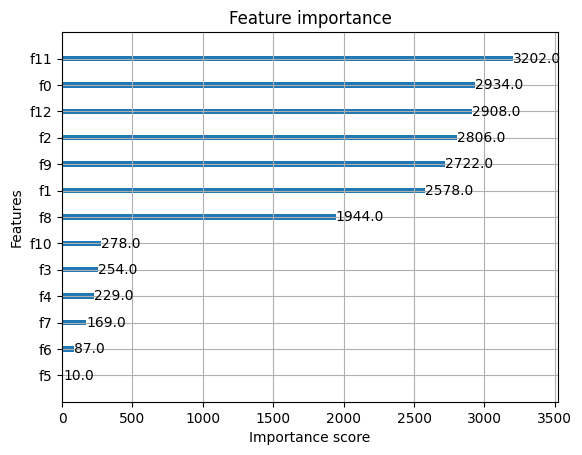


RMSE Final: 40010.35
MAE Final: 26884.42


In [ ]:
# treinar modelo final com melhores parâmetros
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

# feature Importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(best_model, max_num_features=15)
plt.show()

# previsões finais
final_preds = best_model.predict(X_test_scaled)
print(f"\nRMSE Final: {np.sqrt(mean_squared_error(y_test, final_preds)):.2f}")
print(f"MAE Final: {mean_absolute_error(y_test, final_preds):.2f}")